In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models and preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
# ML algorithms (baseline + advanced)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## 📂 Step 2: Data Loading & Initial Exploration

In this step, we will:

- Load the dataset into a Pandas DataFrame  
- Check the shape (rows × columns)  
- Preview the first few rows to understand the structure  
- Display column information (data types, null values)  

This gives us the **first feel of the dataset** before cleaning or transformation.

In [2]:
# 2.1 Load the Dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")

# 2.2 Check Shape
print("Shape of training data:", train_df.shape)

# 2.3 Preiew Data
train_df.head()

# 2.4 Column Info
train_df.info()

# 2.5 Missing Values
train_df.isnull().sum()

Shape of training data: (750000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## 📂 Step 2: Data Loading & Initial Exploration  

### 🔎 Key Observations  

- The dataset contains **750,000 rows** and **18 columns**.  
- Columns are a mix of **numeric (int64)** and **categorical (object)**:  
  - **Numeric (9 columns)**: `id, age, balance, day, month, duration, campaign, pdays, previous, y`.  
  - **Categorical (9 columns)**: `job, marital, education, default, housing, loan, contact, poutcome`.  
- The target variable is **`y`**, which is binary (0 = No, 1 = Yes).  
- **No missing values** detected in any column.  
- Memory usage is around **103 MB**, which is efficient enough for in-memory analysis.  

📌 This confirms the dataset is **clean and complete**, so we can proceed with **Exploratory Data Analysis (EDA)**.  

## 📊 Step 3: Exploratory Data Analysis (EDA)

In this step, we will:
- Generate summary statistics for numerical features
- Visualize distributions of numerical variables
- Analyze categorical feature frequencies
- Explore the target variable balance (`y`)
- Check correlations among numerical features

This helps us understand **data patterns, imbalance, and relationships** before model building.

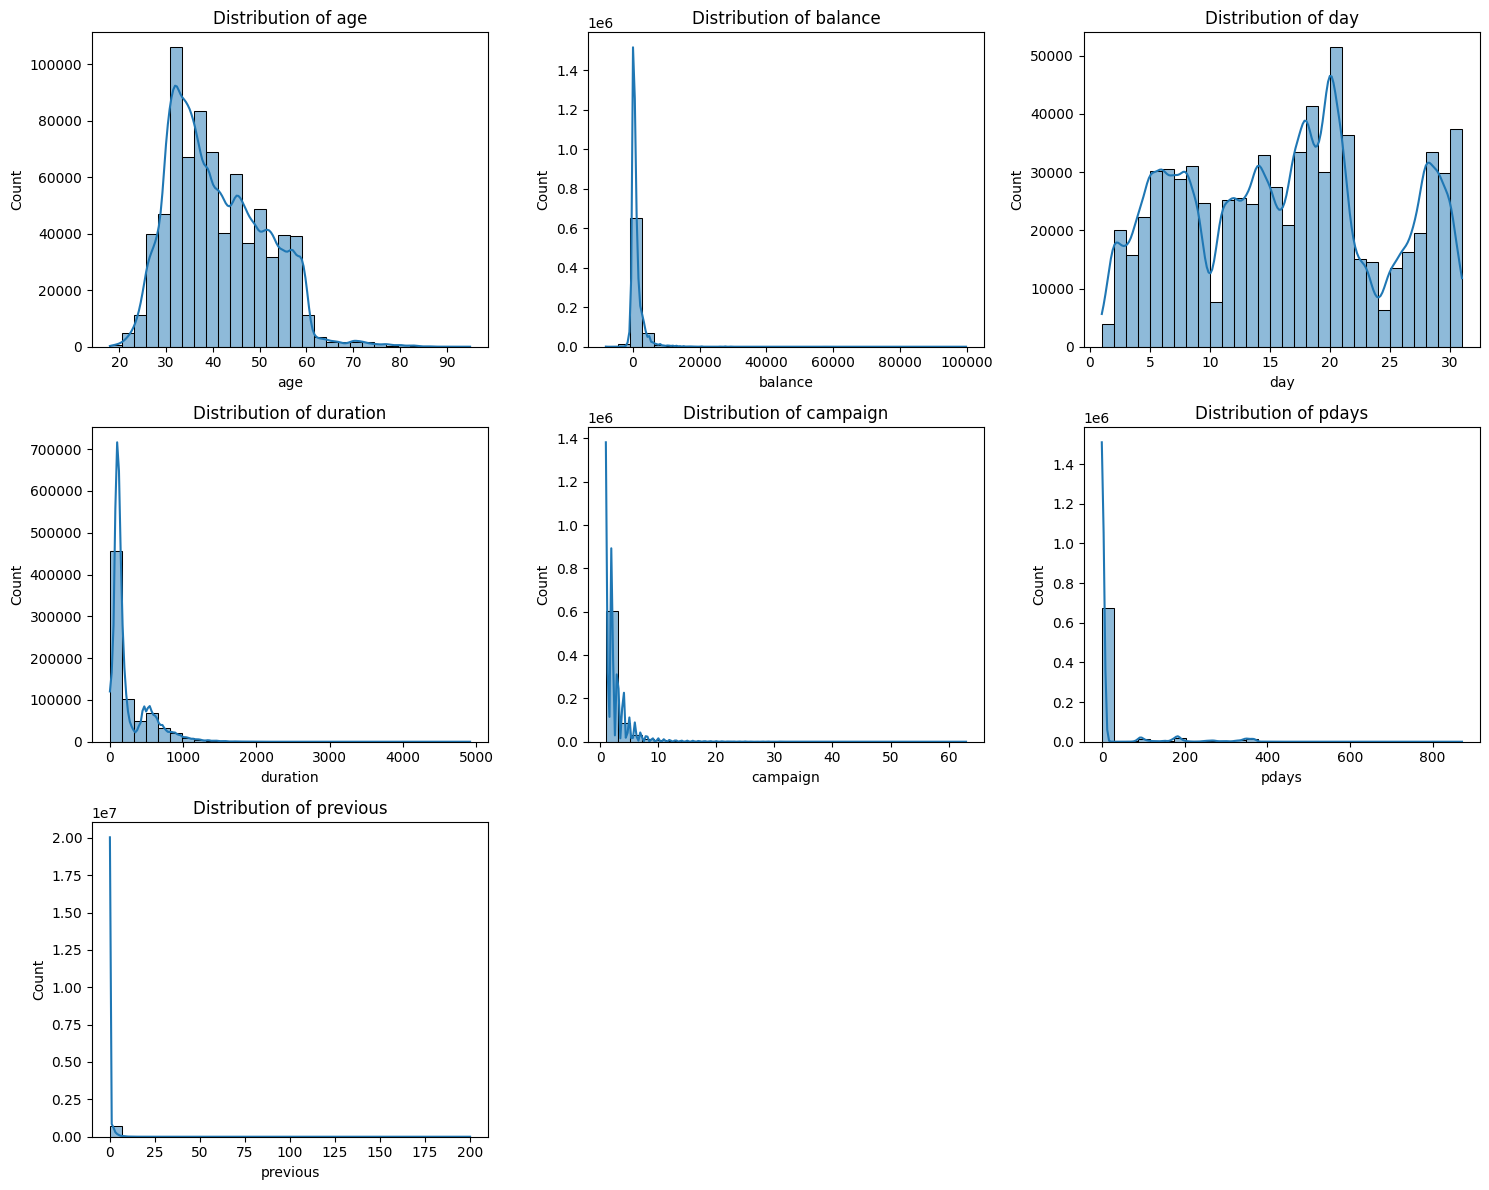

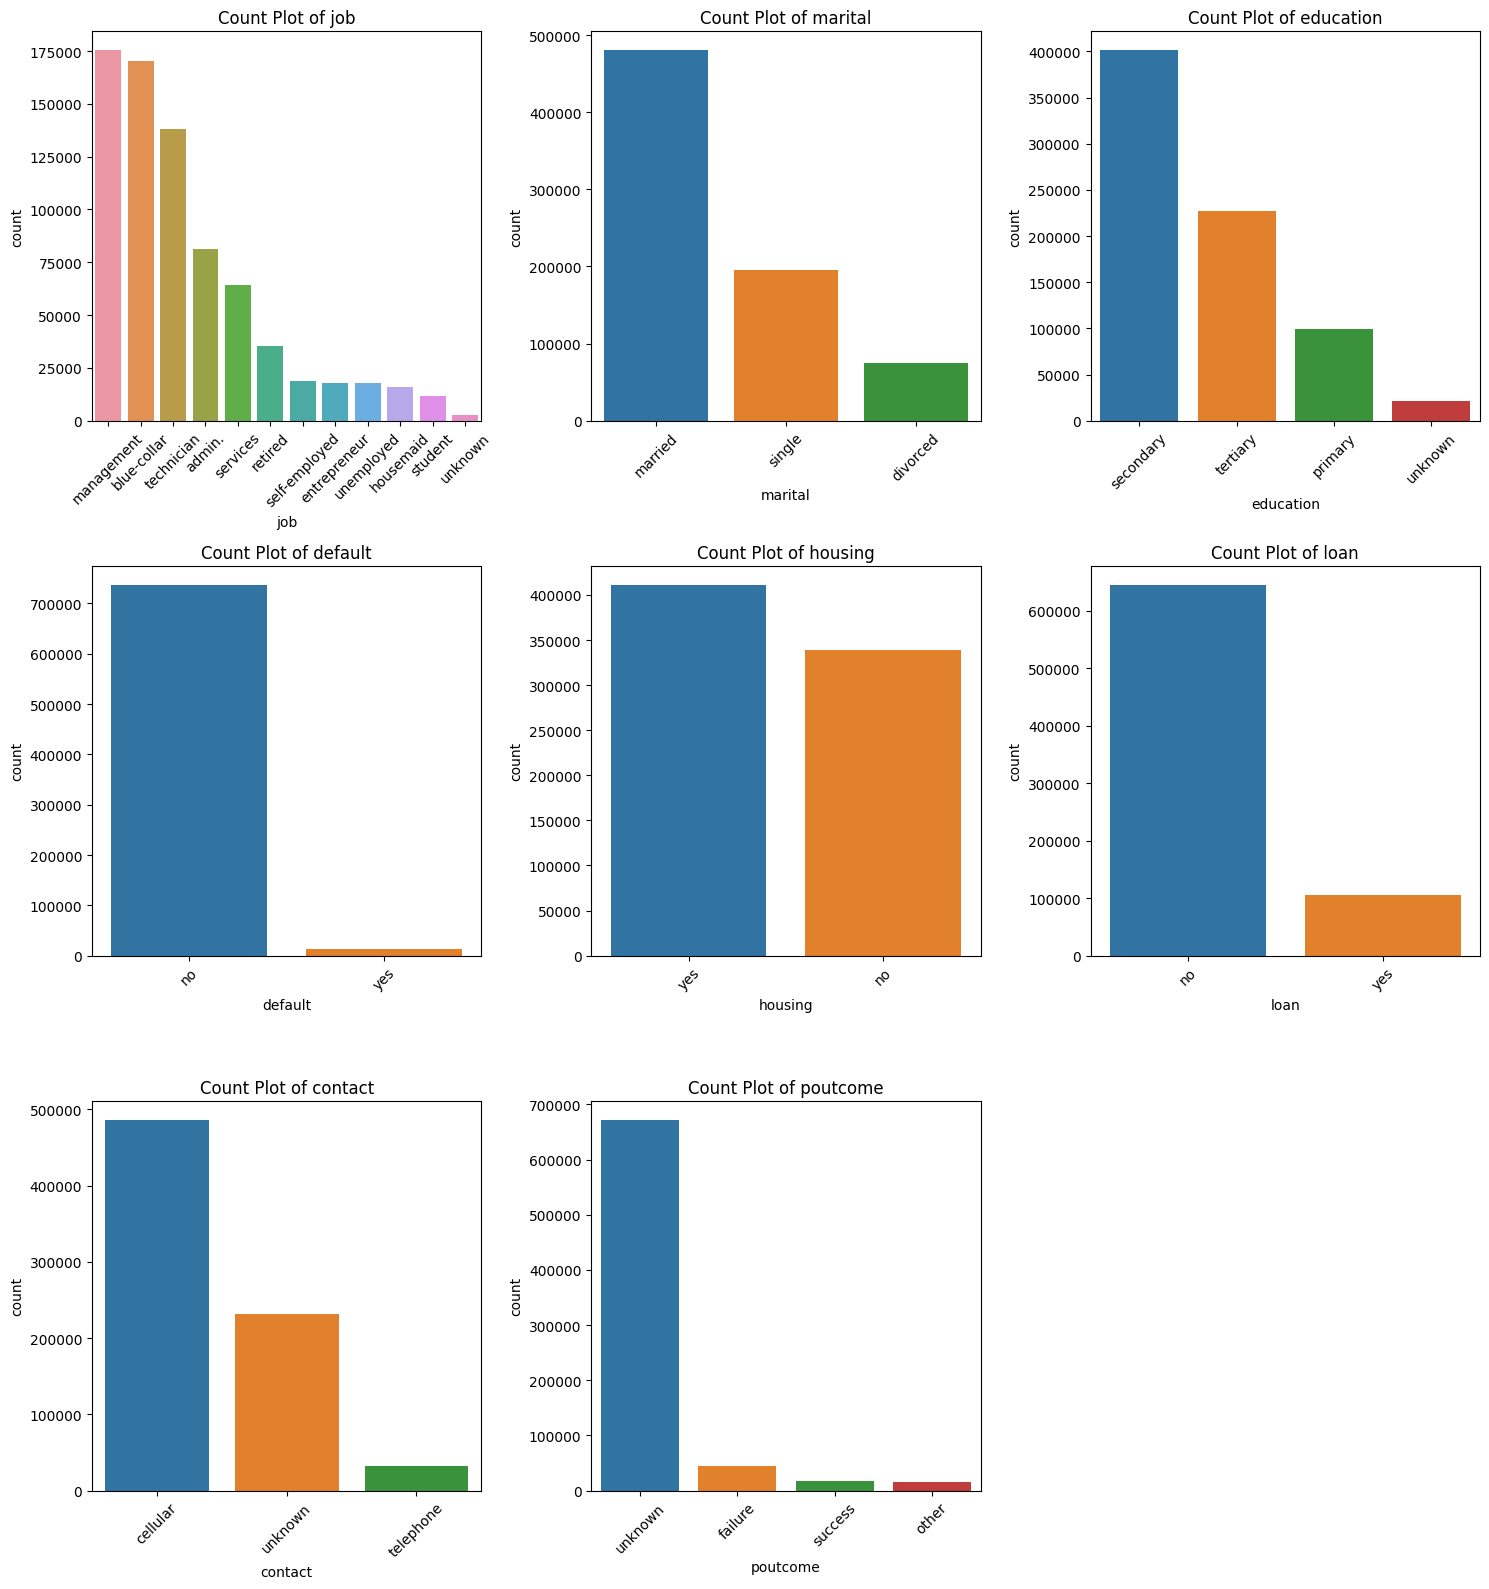

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


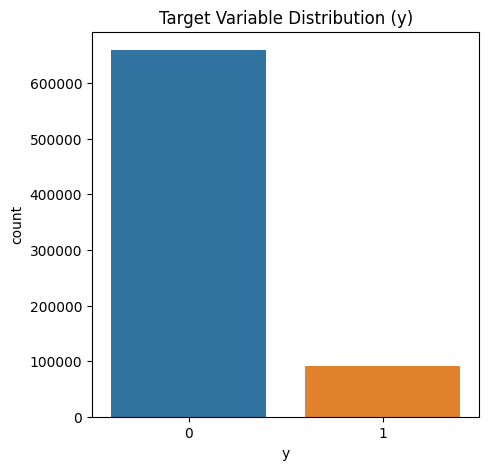

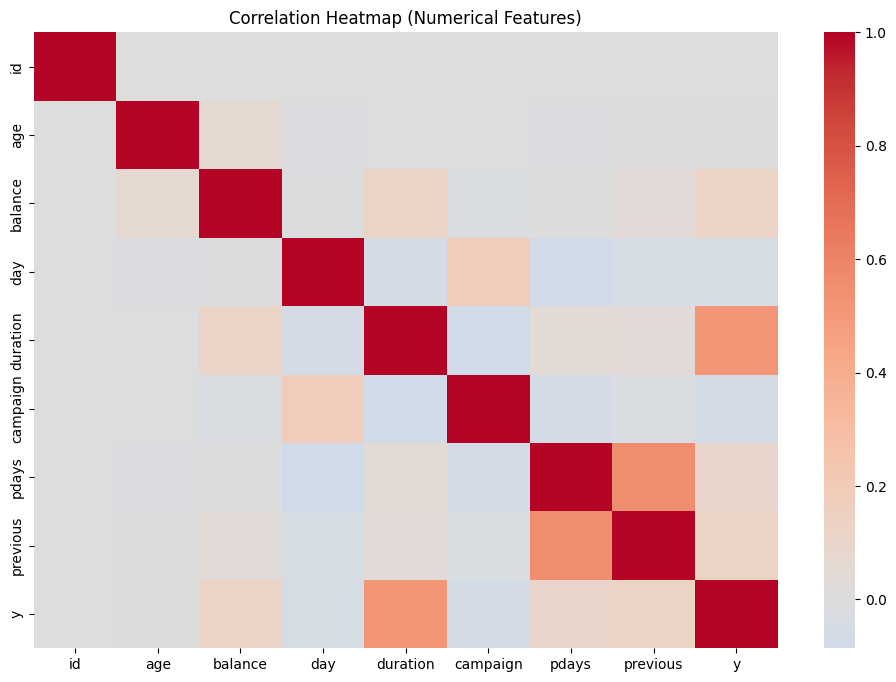

In [3]:
# 3.1 Summary Statistics
train_df.describe().T

# 3.2 Distribution of Numerical Features
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 3.3 Categorical Feature Analysis
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

plt.figure(figsize=(15, 16))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index)
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.4 Target Variable Balance
print(train_df['y'].value_counts(normalize=True))

plt.figure(figsize=(5,5))
sns.countplot(data=train_df, x='y')
plt.title("Target Variable Distribution (y)")
plt.show()

# 3.5 Correlation Heatmap
plt.figure(figsize=(12,8))
corr = train_df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

## 📊 Step 3: Exploratory Data Analysis (EDA)  

### 🔹 3.1 Distribution of Numerical Features  
- **Age**: Most clients fall between **30–50 years old**, indicating a middle-aged customer base.  
- **Balance**: Extremely **right-skewed** — majority have low or near-zero balances, but there are a few very large outliers (>50,000).  
- **Day**: Fairly **uniform distribution** across the month, suggesting calls were spread evenly.  
- **Duration**: Heavily **right-skewed** — most calls are short, but some lasted up to several thousand seconds. Since duration is strongly correlated with outcome, it may not be a good predictor before the call (possible data leakage).  
- **Campaign**: Most clients were contacted less than 5 times, with a few extreme cases >50.  
- **Pdays**: Strong spike at **999**, which usually represents “not previously contacted.” This dominates the variable.  
- **Previous**: Vast majority had **0 previous contacts**, making it highly imbalanced.  

---

### 🔹 3.2 Categorical Feature Analysis  
- **Job**: Most frequent categories are **management, blue-collar, technician**. Rare jobs include student, unemployed, unknown.  
- **Marital**: Majority are **married**, followed by single, then divorced.  
- **Education**: Highest in **secondary education**, followed by tertiary, then primary.  
- **Default**: Almost all are **“no”**, with very few defaults.  
- **Housing**: Slightly more clients have **housing loans** than not.  
- **Loan**: Majority **do not** have personal loans.  
- **Contact**: Predominantly contacted via **cellular**, with fewer via telephone and many marked as “unknown.”  
- **Poutcome**: Overwhelmingly “unknown,” with very few “success” or “failure.”  

---

### 🔹 3.3 Target Variable (`y`) Balance  
- The dataset is **highly imbalanced**:  
  - **~87% → No subscription (y = 0)**  
  - **~13% → Subscription (y = 1)**  
- This imbalance will affect model training, so methods like **SMOTE, undersampling, oversampling, or class weights** will be important.  

---

### 🔹 3.4 Correlation Analysis (Numerical Features Only)  
- Most numerical features have **low correlation** with the target (`y`).  
- **Duration** shows a stronger positive correlation with subscription, but it must be treated carefully due to possible **data leakage** (since duration is only known after the call).  
- **Pdays** and **Previous** are moderately correlated with each other, indicating some redundancy.  
- **Balance** has weak correlation with outcome, but extreme outliers may influence results.  

---

### 📌 Key Takeaways from EDA  
1. **Imbalanced Target** → Models need to handle class imbalance explicitly.  
2. **Skewed Numerical Features** → Features like `balance, duration, campaign, pdays, previous` require transformation (log scaling or capping outliers).  
3. **High Cardinality Categorical Variables** (`job, education`) → Require careful encoding (e.g., target encoding or frequency encoding instead of naive one-hot).  
4. **Duration Variable** → Strong predictive power but may lead to leakage → consider building models with and without it.  
5. **Contact & Poutcome** → Large proportion of “unknown,” making them less reliable predictors.  

---

✅ With these insights, we are ready to move on to **Step 4: Data Preprocessing & Feature Engineering**, where we’ll handle encoding, scaling, and imbalance.  


## ⚙️ Step 4: Data Preprocessing & Feature Engineering  

In this step, we will:  
- Encode categorical features (convert text → numeric)  
- Scale numerical features for model stability  
- Handle class imbalance in the target variable  
- Split data into training & validation sets  

This ensures the dataset is **clean, numeric, and balanced** for machine learning models.

In [4]:
# 4.1 Separate Features and Target
X = train_df.drop(columns=['id','y'])   # drop id (not useful) and target
y = train_df['y']

# 4.2 Encode Categorical Variables
cat_cols = X.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# 4.3 Scale Numerical Features
num_cols = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4.4 Train-Test Split (no SMOTE here)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("\nTarget distribution in train set:\n", y_train.value_counts(normalize=True))

Train set shape: (600000, 16)
Validation set shape: (150000, 16)

Target distribution in train set:
 y
0    0.87935
1    0.12065
Name: proportion, dtype: float64


## 🤖 Step 5: Baseline Model Training  

In this step, we will:  
- Train multiple baseline classifiers (Logistic Regression, Random Forest, XGBoost, LightGBM)  
- Use `class_weight="balanced"` to address imbalance  
- Evaluate models on validation set using **ROC AUC**  
- Compare performance across models  

This gives us a **starting benchmark** before hyperparameter tuning.


In [5]:
# 5.1 Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict_proba(X_valid)[:,1]
auc_log = roc_auc_score(y_valid, y_pred_log)

# 5.2 Random Forest
rf = RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_valid)[:,1]
auc_rf = roc_auc_score(y_valid, y_pred_rf)

# 5.3 XGBoost
xgb = XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_valid)[:,1]
auc_xgb = roc_auc_score(y_valid, y_pred_xgb)

# 5.4 LightGBM  (rename from `lgb` -> `lgb_base`)
lgb_base = LGBMClassifier(class_weight="balanced", random_state=42, n_estimators=200)
lgb_base.fit(X_train, y_train)
y_pred_lgb = lgb_base.predict_proba(X_valid)[:,1]
auc_lgb = roc_auc_score(y_valid, y_pred_lgb)

# 5.5 Compare Results
print("ROC AUC Scores:")
print(f"Logistic Regression: {auc_log:.4f}")
print(f"Random Forest: {auc_rf:.4f}")
print(f"XGBoost: {auc_xgb:.4f}")
print(f"LightGBM: {auc_lgb:.4f}")

[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC Scores:
Logistic Regression: 0.9228
Random Forest: 0.9632
XGBoost: 0.9657
LightGBM: 0.9662


## 🤖 Step 5: Baseline Model Training – Results & Analysis  

### 🔹 ROC AUC Scores (Validation Set)
- Logistic Regression: **0.9228**  
- Random Forest: **0.9632**  
- XGBoost: **0.9657**  
- LightGBM: **0.9662**  

### 🔎 Observations
1. **Logistic Regression** provides a solid baseline (AUC ~0.92), but non-linear models clearly outperform it.  
2. **Random Forest** already shows a large jump in performance (~0.96 AUC).  
3. **XGBoost and LightGBM** outperform Random Forest, with **LightGBM slightly ahead (0.9662)**.  
4. Both boosting models are strong candidates for final submission, but LightGBM seems the best starting point.  

### 📌 Key Insights
- The models are learning useful patterns even with class imbalance handled by `class_weight`.  
- Tree-based models (RF, XGB, LGBM) handle categorical encodings and non-linearities better than linear methods.  
- Further performance gains will likely come from **hyperparameter tuning** and **ensemble stacking**.  

---

## ⚡ Step 6 : Lightweight Tuning with Optuna (Hold-out, Early Stopping)

- Stratified **subsample** from the train split for tuning (≤ 200k rows)
- Use a **single hold-out** for tuning (no CV)
- **Early stopping** and **tight param ranges** keep it quick
- Train best params on the full train split and evaluate on our validation set

In [6]:
# --- prevent shadowing of the lightgbm module ---
if "lgb" in globals() and not hasattr(lgb, "__package__"):
    # a model instance named `lgb` exists; remove it
    del lgb

import lightgbm as lgb
from lightgbm import LGBMClassifier


RANDOM_STATE = 42
TUNE_SIZE = min(len(X_train), 200_000)   # subsample size for tuning
TEST_SIZE_TUNE = 0.2                     # split inside the tuning sample
N_TRIALS_LGB = 12                        # keep small for speed
N_TRIALS_XGB = 12

# ---- 6.1 Stratified subsample for tuning ----
if len(X_train) > TUNE_SIZE:
    tune_idx, _ = next(iter(
        StratifiedKFold(n_splits=int(len(X_train)/TUNE_SIZE), shuffle=True,
                        random_state=RANDOM_STATE).split(X_train, y_train)
    ))
    X_tune_full = X_train.iloc[tune_idx].copy()
    y_tune_full = y_train.iloc[tune_idx].copy()
else:
    X_tune_full, y_tune_full = X_train.copy(), y_train.copy()

X_tune_tr, X_tune_va, y_tune_tr, y_tune_va = train_test_split(
    X_tune_full, y_tune_full, test_size=TEST_SIZE_TUNE,
    stratify=y_tune_full, random_state=RANDOM_STATE
)

# Imbalance ratio for XGB
pos = y_tune_tr.sum()
neg = len(y_tune_tr) - pos
SCALE_POS_WEIGHT = neg / max(pos, 1)

# ---- 6.2 Fast LGBM tuning (hold-out) ----
def objective_lgb(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "random_state": RANDOM_STATE,
        "class_weight": "balanced",
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_jobs": -1,
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_tune_tr, y_tune_tr,
        eval_set=[(X_tune_va, y_tune_va)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )
    pred = model.predict_proba(X_tune_va)[:, 1]
    return roc_auc_score(y_tune_va, pred)

study_lgb = optuna.create_study(direction="maximize", study_name="LGBM-fast",
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=4))
study_lgb.optimize(objective_lgb, n_trials=N_TRIALS_LGB, show_progress_bar=False)
print("LGBM best AUC (tune hold-out):", study_lgb.best_value)
print("LGBM best params:", study_lgb.best_params)

best_lgb = LGBMClassifier(**study_lgb.best_params, objective="binary",
                          metric="auc", class_weight="balanced",
                          random_state=RANDOM_STATE, n_jobs=-1)

best_lgb.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=120, verbose=False)]
)
lgb_valid_auc = roc_auc_score(y_valid, best_lgb.predict_proba(X_valid)[:, 1])
print(f"Validation AUC (LGBM tuned fast): {lgb_valid_auc:.5f}")

# ---- 6.3 Fast XGB tuning (hold-out) ----
def objective_xgb(trial):
    params = {
        "tree_method": "hist",
        "eval_metric": "auc",
        "random_state": RANDOM_STATE,
        "scale_pos_weight": float(SCALE_POS_WEIGHT),
        "n_estimators": trial.suggest_int("n_estimators", 250, 700),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_jobs": -1,
    }
    model = XGBClassifier(**params)
    model.fit(
        X_tune_tr, y_tune_tr,
        eval_set=[(X_tune_va, y_tune_va)],
        verbose=False,
        early_stopping_rounds=80
    )
    pred = model.predict_proba(X_tune_va)[:, 1]
    return roc_auc_score(y_tune_va, pred)

study_xgb = optuna.create_study(direction="maximize", study_name="XGB-fast",
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=4))
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS_XGB, show_progress_bar=False)
print("XGB best AUC (tune hold-out):", study_xgb.best_value)
print("XGB best params:", study_xgb.best_params)

best_xgb = XGBClassifier(**study_xgb.best_params, tree_method="hist",
                         eval_metric="auc", random_state=RANDOM_STATE, n_jobs=-1,
                         scale_pos_weight=float(SCALE_POS_WEIGHT))
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
    early_stopping_rounds=120
)
xgb_valid_auc = roc_auc_score(y_valid, best_xgb.predict_proba(X_valid)[:, 1])
print(f"Validation AUC (XGB tuned fast): {xgb_valid_auc:.5f}")

# ---- 6.4 Pick model for inference ----
print("\n=== Fast Tuned Model Comparison (Validation AUC) ===")
print(f"LightGBM: {lgb_valid_auc:.5f} | XGBoost: {xgb_valid_auc:.5f}")
best_model_name = "LightGBM" if lgb_valid_auc >= xgb_valid_auc else "XGBoost"
print("Selected for inference:", best_model_name)

final_model = best_lgb if best_model_name == "LightGBM" else best_xgb


[I 2025-08-30 16:01:48,943] A new study created in memory with name: LGBM-fast


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:01:57,451] Trial 0 finished with value: 0.960089711250429 and parameters: {'n_estimators': 366, 'learning_rate': 0.023215091528649937, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 113, 'subsample': 0.7824637437280121, 'colsample_bytree': 0.832513940232484, 'reg_alpha': 1.6884398769149929, 'reg_lambda': 3.6910399129611466}. Best is trial 0 with value: 0.960089711250429.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:02:07,490] Trial 1 finished with value: 0.9632535735374744 and parameters: {'n_estimators': 448, 'learning_rate': 0.0343767603195618, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.7476758688459465, 'colsample_bytree': 0.8526867849337942, 'reg_alpha': 0.27372588269240217, 'reg_lambda': 0.623322912694928}. Best is trial 1 with value: 0.9632535735374744.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2025-08-30 16:02:17,142] Trial 2 finished with value: 0.962908904346731 and parameters: {'n_estimators': 310, 'learning_rate': 0.023897900316680456, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 106, 'subsample': 0.9837753043525121, 'colsample_bytree': 0.7281609631256125, 'reg_alpha': 0.7038519414971045, 'reg_lambda': 2.4087851023119606}. Best is trial 1 with value: 0.9632535735374744.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:02:31,750] Trial 3 finished with value: 0.9643288941371121 and parameters: {'n_estimators': 563, 'learning_rate': 0.030293781055693098, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 90, 'subsample': 0.8935117244361876, 'colsample_bytree': 0.7004707491525631, 'reg_alpha': 1.8598748320129432, 'reg_lambda': 3.352725338276909}. Best is trial 3 with value: 0.9643288941371121.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2025-08-30 16:02:37,340] Trial 4 finished with value: 0.962123997326794 and parameters: {'n_estimators': 200, 'learning_rate': 0.03868832932555826, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 114, 'subsample': 0.7750582135294004, 'colsample_bytree': 0.7057975486474366, 'reg_alpha': 0.36249859791048444, 'reg_lambda': 3.880759731458438}. Best is trial 3 with value: 0.9643288941371121.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:02:43,584] Trial 5 finished with value: 0.9651940575467447 and parameters: {'n_estimators': 282, 'learning_rate': 0.1473050472658271, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7820692788155499, 'colsample_bytree': 0.7982193235808092, 'reg_alpha': 2.5423677742875346, 'reg_lambda': 4.401465524797332}. Best is trial 5 with value: 0.9651940575467447.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:02:49,722] Trial 6 finished with value: 0.95547080315135 and parameters: {'n_estimators': 287, 'learning_rate': 0.020706116140474913, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 61, 'subsample': 0.879201618141541, 'colsample_bytree': 0.8777605978305056, 'reg_alpha': 3.4159125286280254, 'reg_lambda': 2.8874320908997477}. Best is trial 5 with value: 0.9651940575467447.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:02:56,201] Trial 7 finished with value: 0.9638126613389957 and parameters: {'n_estimators': 332, 'learning_rate': 0.08484573259763094, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 108, 'subsample': 0.7961773664820612, 'colsample_bytree': 0.8116953334248147, 'reg_alpha': 1.056829219219323, 'reg_lambda': 0.25063712137101846}. Best is trial 5 with value: 0.9651940575467447.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:03:08,031] Trial 8 finished with value: 0.965695902250775 and parameters: {'n_estimators': 423, 'learning_rate': 0.047847396509294454, 'num_leaves': 92, 'max_depth': 10, 'min_child_samples': 103, 'subsample': 0.8272866004403943, 'colsample_bytree': 0.8850365589127653, 'reg_alpha': 4.5323509451355335, 'reg_lambda': 1.4025696421325136}. Best is trial 8 with value: 0.965695902250775.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-30 16:03:16,548] Trial 9 finished with value: 0.965684718138334 and parameters: {'n_estimators': 347, 'learning_rate': 0.08465541888600259, 'num_leaves': 68, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.9829741459482841, 'colsample_bytree': 0.7644614006373508, 'reg_alpha': 2.253592758503504, 'reg_lambda': 2.4745772479394157}. Best is trial 8 with value: 0.965695902250775.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2025-08-30 16:03:26,407] Trial 10 finished with value: 0.9651852732909305 and parameters: {'n_estimators': 469, 'learning_rate': 0.053506129200027695, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.7055269222878592, 'colsample_bytree': 0.9712960624075903, 'reg_alpha': 4.802871827376912, 'reg_lambda': 1.3071943175868954}. Best is trial 8 with value: 0.965695902250775.


[LightGBM] [Info] Number of positive: 38608, number of negative: 281392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2025-08-30 16:03:35,978] Trial 11 finished with value: 0.9657771807334425 and parameters: {'n_estimators': 427, 'learning_rate': 0.08273089632791417, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 86, 'subsample': 0.9983452363258798, 'colsample_bytree': 0.9221568311453769, 'reg_alpha': 3.9715176131718692, 'reg_lambda': 1.9683024214603946}. Best is trial 11 with value: 0.9657771807334425.


LGBM best AUC (tune hold-out): 0.9657771807334425
LGBM best params: {'n_estimators': 427, 'learning_rate': 0.08273089632791417, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 86, 'subsample': 0.9983452363258798, 'colsample_bytree': 0.9221568311453769, 'reg_alpha': 3.9715176131718692, 'reg_lambda': 1.9683024214603946}
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-30 16:03:53,761] A new study created in memory with name: XGB-fast


Validation AUC (LGBM tuned fast): 0.96792


[I 2025-08-30 16:04:04,389] Trial 0 finished with value: 0.9646688755440921 and parameters: {'n_estimators': 294, 'learning_rate': 0.041707729239829225, 'max_depth': 10, 'min_child_weight': 6.032154285457237, 'subsample': 0.769610753620819, 'colsample_bytree': 0.917188580304404, 'gamma': 0.7446799435334089, 'reg_alpha': 3.528786397860924, 'reg_lambda': 0.4788026706918974}. Best is trial 0 with value: 0.9646688755440921.
[I 2025-08-30 16:04:16,816] Trial 1 finished with value: 0.9647879339114567 and parameters: {'n_estimators': 541, 'learning_rate': 0.13812061849754526, 'max_depth': 5, 'min_child_weight': 6.035714295467357, 'subsample': 0.8421714119077376, 'colsample_bytree': 0.9933194652504989, 'gamma': 4.396207327919402, 'reg_alpha': 3.1411815963093708, 'reg_lambda': 1.0653884558801363}. Best is trial 1 with value: 0.9647879339114567.
[I 2025-08-30 16:04:26,356] Trial 2 finished with value: 0.9648565952896629 and parameters: {'n_estimators': 417, 'learning_rate': 0.12064253440436647, 

XGB best AUC (tune hold-out): 0.9654095004596297
XGB best params: {'n_estimators': 604, 'learning_rate': 0.07135577697538366, 'max_depth': 8, 'min_child_weight': 8.58026915163306, 'subsample': 0.7042380082349115, 'colsample_bytree': 0.7027670988914564, 'gamma': 4.831515575573468, 'reg_alpha': 4.954515611557017, 'reg_lambda': 4.936939748127892}
Validation AUC (XGB tuned fast): 0.96761

=== Fast Tuned Model Comparison (Validation AUC) ===
LightGBM: 0.96792 | XGBoost: 0.96761
Selected for inference: LightGBM


## 📤 Step 7: Final Training, Test Inference & Submission  

In this step, we will:  
- Retrain the selected best model (**LightGBM**) on the full training dataset  
- Predict probabilities on the **test set**  
- Save results in the required Kaggle format (`id,y`)  
- Ready the submission file `submission.csv`

In [7]:
# 7.1 Load Test Set
test_df = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
test_ids = test_df['id']

# Encode categorical features (same encoders as training)
for col in cat_cols:
    test_df[col] = le.fit_transform(test_df[col])

# Scale numerical columns
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Drop id
X_test = test_df.drop(columns=['id'])

# 7.2 Retrain final model on full training data
final_model.fit(
    X, y,
    eval_metric="auc",
    callbacks=[lgb.log_evaluation(100)]  # prints every 100 rounds, remove if you want silence
)

# 7.3 Predict probabilities for submission
test_preds = final_model.predict_proba(X_test)[:, 1]

# 7.4 Create submission file
submission = pd.DataFrame({"id": test_ids, "y": test_preds})
submission.to_csv("submission.csv", index=False)

print("✅ Submission file created: submission.csv")
submission.head()


[LightGBM] [Info] Number of positive: 90488, number of negative: 659512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Submission file created: submission.csv


,id,y
0,750000,0.018580
1,750001,0.286917
2,750002,0.001927
3,750003,0.000290
4,750004,0.079739


## 🧠 Step 8: Lightweight Ensemble (LGBM + XGB)

In this step, we will:
- Generate validation & test probabilities from the tuned LightGBM and XGBoost
- Grid-search a simple **blend weight** on the validation set (fast)
- Try a **rank-average** for robustness
- Export the best-performing blend as `submission.csv`


In [8]:
# 8.1 Validation predictions from tuned models
valid_lgb = best_lgb.predict_proba(X_valid)[:, 1]
valid_xgb = best_xgb.predict_proba(X_valid)[:, 1]

# 8.2 Fast weight search on validation to maximize ROC-AUC
weights = np.linspace(0, 1, 21)  # 0.00, 0.05, ..., 1.00
best_w, best_auc = None, -1.0
for w in weights:
    blend = w * valid_lgb + (1 - w) * valid_xgb
    auc = roc_auc_score(y_valid, blend)
    if auc > best_auc:
        best_auc, best_w = auc, w

print(f"Best prob-blend weight (LGBM): {best_w:.2f} | Val AUC: {best_auc:.5f}")

# 8.3 Rank-average (more robust to calibration)
rank_lgb = pd.Series(valid_lgb).rank(pct=True).values
rank_xgb = pd.Series(valid_xgb).rank(pct=True).values
rank_blend_val = 0.5 * rank_lgb + 0.5 * rank_xgb
rank_auc = roc_auc_score(y_valid, rank_blend_val)
print(f"Rank-average Val AUC: {rank_auc:.5f}")

# 8.4 Pick the better validation strategy
use_rank = rank_auc > best_auc
print("Using rank-average" if use_rank else f"Using prob-blend (w={best_w:.2f})")

# 8.5 Test predictions & final blend
test_lgb = best_lgb.predict_proba(X_test)[:, 1]
test_xgb = best_xgb.predict_proba(X_test)[:, 1]

if use_rank:
    test_pred = 0.5 * pd.Series(test_lgb).rank(pct=True).values + \
                0.5 * pd.Series(test_xgb).rank(pct=True).values
else:
    test_pred = best_w * test_lgb + (1 - best_w) * test_xgb

# 8.6 Create final submission (Kaggle picks files from /kaggle/working)
submission = pd.DataFrame({"id": test_ids, "y": test_pred})
out_path = "/kaggle/working/submission.csv"
submission.to_csv(out_path, index=False)

print("✅ Saved ensemble submission to:", out_path)
print(submission.head())

Best prob-blend weight (LGBM): 1.00 | Val AUC: 0.97232
Rank-average Val AUC: 0.97041
Using prob-blend (w=1.00)
✅ Saved ensemble submission to: /kaggle/working/submission.csv
       id         y
0  750000  0.018580
1  750001  0.286917
2  750002  0.001927
3  750003  0.000290
4  750004  0.079739


In [9]:
# --- Create submission in the Kaggle working directory ---
#submission = pd.DataFrame({"id": test_ids, "y": test_preds})

# sanity checks
#assert "id" in submission.columns and "y" in submission.columns, "Columns must be exactly ['id','y']"
#assert submission["id"].is_monotonic_increasing or submission["id"].is_monotonic_decreasing, "IDs look unordered—still ok, but FYI"
#assert submission["y"].between(0,1).all(), "y must be probabilities in [0,1]"

#out_path = "/kaggle/working/submission.csv"
#submission.to_csv(out_path, index=False)

# verify
#import os
#print("Saved to:", out_path)
#print("File size (bytes):", os.path.getsize(out_path))
#print(submission.head(3))

# list working dir so Kaggle picks it up as an Output artifact
#print("\nFiles in /kaggle/working:")
##rint(os.listdir("/kaggle/working"))